__PHARML 2022 CHALLENGE - SURVIVAL ANALYSIS MODELING SECTION 

Prognostic models have a wide-array of applications and are used in academic and clinical settings. Lung cancer is newly diagnosed in 2.3 million people per year and is divided in Non-Small Cell Lung Cancer (NSCLC) and Small Cell Lung Cancer (SCLC). NSCLC accounts for 84% of the total cases. The 5-year survival rate for patients with NSCLC is 25%, but prognosis can vary depending on many factors including demographics, clinical characteristics, and genomic mutations, among others. Survival Machine Learning models could enable us to make much better prognosis prediction, which in turn has real world clinical applications. Prognostic models could be used to help us identify the most predictive and novel biomarkers influencing the risk of mortality in NSCLC. Additionally, representations learned by fitting Survival Machine Learning models on NSCLC data could be used to stratify patients and obtain clinical clusters or phenotypes that give us insights on disease heterogeneity. Yet another promising application for these models is the potential use of covariate adjustment methods to increase the power of clinical trials and achieve significant results with fewer patients. Finally, it should be noted that there are many other potential relevant real-world applications for these methods.

In [2]:
#Import Library
library(dplyr)
library(ggplot2)
library(tidyr)
library(caret)
library(lubridate)
library(purrr)
library(mgcv)
library(rpart)
library(tidyverse)
library(utils)
library(broom)
library(ellipsis)
library(highr)
library(lattice)
library(methods)
library(nlme)
library(readr)
library(readxl)
library(stats)
library(stringr)
library(ranger)
library(tibble)
library(xgboost)
library(magrittr)
library(lubridate)
library(xts)
library(hms)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘purrr’


The following object is masked from ‘package:caret’:

    lift


Warning message:
“package ‘mgcv’ was built under R version 4.1.3”
Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────

In [3]:
#Load in dataframe
flatiron_train <- read_csv("/pharml/data/flatiron_training.csv")
head(flatiron_train)

Rows: 31334 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): patientid, ecog, histology, groupstage, smokingstatus, gender, rac...
dbl  (7): daysto_event, event_died, diagnosis_nsclc_year, diagnosis_ansclc_y...
lgl  (6): biomarker_pdl1, biomarker_alk, biomarker_ros1, biomarker_braf, bio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


patientid,daysto_event,event_died,diagnosis_nsclc_year,diagnosis_ansclc_year,ecog,histology,groupstage,smokingstatus,birthyear,⋯,biomarker_alk,biomarker_ros1,biomarker_braf,biomarker_egfr,biomarker_kras,lab_creatinine,lab_alanineaminotransferase,lab_ldh,bmi,index_lot1_year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
PHARML000001,156,0,2002,2019,1,Squamous cell carcinoma,Stage IIA,History of smoking,1951,⋯,NA,NA,NA,NA,NA,normal,normal,NA,19.34262,2019
PHARML000003,190,1,2013,2014,Unknown,Non-squamous cell carcinoma,Stage IIIA,History of smoking,1946,⋯,NA,NA,NA,NA,NA,NA,normal,NA,22.41903,2014
PHARML000004,74,1,2020,2020,Unknown,Non-squamous cell carcinoma,Stage IIIC,History of smoking,1944,⋯,NA,NA,NA,NA,NA,NA,NA,NA,26.63880,2020
PHARML000008,52,1,2020,2020,1,Non-squamous cell carcinoma,Stage IV,History of smoking,1937,⋯,NA,NA,NA,NA,NA,normal,abnormal,NA,18.94848,2020
PHARML000009,392,0,2021,2021,0,Non-squamous cell carcinoma,Stage IIIB,History of smoking,1966,⋯,NA,NA,NA,NA,NA,normal,normal,abnormal,21.33351,2021
PHARML000011,39,1,2017,2017,Unknown,Non-squamous cell carcinoma,Stage IV,History of smoking,1943,⋯,NA,NA,NA,NA,NA,normal,normal,normal,16.65117,2017


In [4]:
summary(flatiron_train)

  patientid          daysto_event      event_died     diagnosis_nsclc_year
 Length:31334       Min.   :   1.0   Min.   :0.0000   Min.   :1990        
 Class :character   1st Qu.: 112.0   1st Qu.:0.0000   1st Qu.:2014        
 Mode  :character   Median : 280.0   Median :1.0000   Median :2016        
                    Mean   : 484.2   Mean   :0.7273   Mean   :2016        
                    3rd Qu.: 639.0   3rd Qu.:1.0000   3rd Qu.:2019        
                    Max.   :3948.0   Max.   :1.0000   Max.   :2022        
                                                      NA's   :5           
 diagnosis_ansclc_year     ecog            histology          groupstage       
 Min.   :2011          Length:31334       Length:31334       Length:31334      
 1st Qu.:2014          Class :character   Class :character   Class :character  
 Median :2017          Mode  :character   Mode  :character   Mode  :character  
 Mean   :2016                                                                  


In [5]:
#Filter to remove the 5 rows with missing values for diagnosis_nsclc_year
flatiron_train1 <- flatiron_train %>% filter(!is.na(diagnosis_nsclc_year))
summary(flatiron_train1)

  patientid          daysto_event      event_died     diagnosis_nsclc_year
 Length:31329       Min.   :   1.0   Min.   :0.0000   Min.   :1990        
 Class :character   1st Qu.: 112.0   1st Qu.:0.0000   1st Qu.:2014        
 Mode  :character   Median : 280.0   Median :1.0000   Median :2016        
                    Mean   : 484.2   Mean   :0.7273   Mean   :2016        
                    3rd Qu.: 639.0   3rd Qu.:1.0000   3rd Qu.:2019        
                    Max.   :3948.0   Max.   :1.0000   Max.   :2022        
                                                                          
 diagnosis_ansclc_year     ecog            histology          groupstage       
 Min.   :2011          Length:31329       Length:31329       Length:31329      
 1st Qu.:2014          Class :character   Class :character   Class :character  
 Median :2017          Mode  :character   Mode  :character   Mode  :character  
 Mean   :2016                                                                  


In [6]:
glimpse(flatiron_train1)

Rows: 31,329
Columns: 25
$ patientid                   <chr> "PHARML000001", "PHARML000003", "PHARML000…
$ daysto_event                <dbl> 156, 190, 74, 52, 392, 39, 1302, 181, 761,…
$ event_died                  <dbl> 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, …
$ diagnosis_nsclc_year        <dbl> 2002, 2013, 2020, 2020, 2021, 2017, 2018, …
$ diagnosis_ansclc_year       <dbl> 2019, 2014, 2020, 2020, 2021, 2017, 2018, …
$ ecog                        <chr> "1", "Unknown", "Unknown", "1", "0", "Unkn…
$ histology                   <chr> "Squamous cell carcinoma", "Non-squamous c…
$ groupstage                  <chr> "Stage IIA", "Stage IIIA", "Stage IIIC", "…
$ smokingstatus               <chr> "History of smoking", "History of smoking"…
$ birthyear                   <dbl> 1951, 1946, 1944, 1937, 1966, 1943, 1946, …
$ gender                      <chr> "M", "F", "M", "F", "M", "F", "F", "F", "M…
$ raceethnicity               <chr> "Hispanic or Latino (any)", "Hispanic or L…
$ region       

In [7]:
install.packages("naniar", "/tmp/RtmpopXkDN/downloaded_packages")

In [7]:
library("naniar", lib.loc=.libPaths("/tmp/RtmpopXkDN/downloaded_packages"))

In [8]:
#Replace '<NA>' values in bmi & smokingstatus columns with NA
flatiron_train1 <- flatiron_train1 %>% replace_with_na(replace = list(bmi = "<NA>"), 
                                                       (lot_category = "<NA>"))


In [9]:
#Replace all NA values in BMI with 19.0
toReplace1 <- which(is.na(flatiron_train1$bmi))
flatiron_train1$bmi[toReplace1] <- 19.0

In [10]:
install.packages("superml", "/tmp/RtmpopXkDN/downloaded_packages")

In [11]:
library("superml", lib.loc=.libPaths("/tmp/RtmpopXkDN/downloaded_packages"))

Loading required package: R6



In [12]:
#Label encode the following categorical variables - groupstage, ecog, smoking status, gender, lab results
# & biomarkers

label <- LabelEncoder$new()
print(label$fit(flatiron_train1$ecog))
flatiron_train1$ecog <- label$fit_transform(flatiron_train1$ecog)

[1] TRUE


In [13]:
#encode groupstage
label <- LabelEncoder$new()
print(label$fit(flatiron_train1$groupstage))
flatiron_train1$groupstage <- label$fit_transform(flatiron_train1$groupstage)

label <- LabelEncoder$new()
print(label$fit(flatiron_train1$smokingstatus))
flatiron_train1$smokingstatus <- label$fit_transform(flatiron_train1$smokingstatus)

label <- LabelEncoder$new()
print(label$fit(flatiron_train1$gender))
flatiron_train1$gender <- label$fit_transform(flatiron_train1$gender)

label <- LabelEncoder$new()
print(label$fit(flatiron_train1$lab_ldh))
flatiron_train1$lab_ldh <- label$fit_transform(flatiron_train1$lab_ldh)

label <- LabelEncoder$new()
print(label$fit(flatiron_train1$lab_alanineaminotransferase))
flatiron_train1$lab_alanineaminotransferase <- label$fit_transform(flatiron_train1$lab_alanineaminotransferase)

label <- LabelEncoder$new()
print(label$fit(flatiron_train1$lab_creatinine))
flatiron_train1$lab_creatinine <- label$fit_transform(flatiron_train1$lab_creatinine)

label <- LabelEncoder$new()
print(label$fit(flatiron_train1$biomarker_pdl1))
flatiron_train1$biomarker_pdl1 <- label$fit_transform(flatiron_train1$biomarker_pdl1)

label <- LabelEncoder$new()
print(label$fit(flatiron_train1$biomarker_alk))
flatiron_train1$biomarker_alk <- label$fit_transform(flatiron_train1$biomarker_alk)

label <- LabelEncoder$new()
print(label$fit(flatiron_train1$biomarker_ros1))
flatiron_train1$biomarker_ros1 <- label$fit_transform(flatiron_train1$biomarker_ros1)

label <- LabelEncoder$new()
print(label$fit(flatiron_train1$biomarker_braf))
flatiron_train1$biomarker_braf <- label$fit_transform(flatiron_train1$biomarker_braf)

label <- LabelEncoder$new()
print(label$fit(flatiron_train1$biomarker_egfr))
flatiron_train1$biomarker_egfr <- label$fit_transform(flatiron_train1$biomarker_egfr)

label <- LabelEncoder$new()
print(label$fit(flatiron_train1$biomarker_kras))
flatiron_train1$biomarker_kras <- label$fit_transform(flatiron_train1$biomarker_kras)

[1] TRUE
[1] TRUE


The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 



In [14]:
unique(flatiron_train1$ecog)

[1] 0 1 2 3 4 5

In [15]:
unique(flatiron_train1$diagnosis_ansclc_year)

[1] 2019 2014 2020 2021 2017 2018 2016 2012 2015 2011 2013 2022

In [16]:
head(flatiron_train1)

patientid,daysto_event,event_died,diagnosis_nsclc_year,diagnosis_ansclc_year,ecog,histology,groupstage,smokingstatus,birthyear,⋯,biomarker_alk,biomarker_ros1,biomarker_braf,biomarker_egfr,biomarker_kras,lab_creatinine,lab_alanineaminotransferase,lab_ldh,bmi,index_lot1_year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PHARML000001,156,0,2002,2019,0,Squamous cell carcinoma,0,0,1951,⋯,0,0,0,0,0,0,0,0,19.34262,2019
PHARML000003,190,1,2013,2014,1,Non-squamous cell carcinoma,1,0,1946,⋯,0,0,0,0,0,1,0,0,22.41903,2014
PHARML000004,74,1,2020,2020,1,Non-squamous cell carcinoma,2,0,1944,⋯,0,0,0,0,0,1,1,0,26.63880,2020
PHARML000008,52,1,2020,2020,0,Non-squamous cell carcinoma,3,0,1937,⋯,0,0,0,0,0,0,2,0,18.94848,2020
PHARML000009,392,0,2021,2021,2,Non-squamous cell carcinoma,4,0,1966,⋯,0,0,0,0,0,0,0,1,21.33351,2021
PHARML000011,39,1,2017,2017,1,Non-squamous cell carcinoma,3,0,1943,⋯,0,0,0,0,0,0,0,2,16.65117,2017


In [17]:
#Mutate in rows for age at diagnosis, time to progress, time to start treatment and treatment to fail
flatiron_train2 <- flatiron_train1 %>% mutate(ageAtdiagnosis = diagnosis_nsclc_year - birthyear, 
    yrsToprogress = diagnosis_ansclc_year - diagnosis_nsclc_year, 
                                              TimetoTx = index_lot1_year - diagnosis_nsclc_year, 
                                            TxtoFail = diagnosis_ansclc_year - index_lot1_year)
head(flatiron_train2)

patientid,daysto_event,event_died,diagnosis_nsclc_year,diagnosis_ansclc_year,ecog,histology,groupstage,smokingstatus,birthyear,⋯,biomarker_kras,lab_creatinine,lab_alanineaminotransferase,lab_ldh,bmi,index_lot1_year,ageAtdiagnosis,yrsToprogress,TimetoTx,TxtoFail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PHARML000001,156,0,2002,2019,0,Squamous cell carcinoma,0,0,1951,⋯,0,0,0,0,19.34262,2019,51,17,17,0
PHARML000003,190,1,2013,2014,1,Non-squamous cell carcinoma,1,0,1946,⋯,0,1,0,0,22.41903,2014,67,1,1,0
PHARML000004,74,1,2020,2020,1,Non-squamous cell carcinoma,2,0,1944,⋯,0,1,1,0,26.63880,2020,76,0,0,0
PHARML000008,52,1,2020,2020,0,Non-squamous cell carcinoma,3,0,1937,⋯,0,0,2,0,18.94848,2020,83,0,0,0
PHARML000009,392,0,2021,2021,2,Non-squamous cell carcinoma,4,0,1966,⋯,0,0,0,1,21.33351,2021,55,0,0,0
PHARML000011,39,1,2017,2017,1,Non-squamous cell carcinoma,3,0,1943,⋯,0,0,0,2,16.65117,2017,74,0,0,0


In [18]:
glimpse(flatiron_train2)

Rows: 31,329
Columns: 29
$ patientid                   <chr> "PHARML000001", "PHARML000003", "PHARML000…
$ daysto_event                <dbl> 156, 190, 74, 52, 392, 39, 1302, 181, 761,…
$ event_died                  <dbl> 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, …
$ diagnosis_nsclc_year        <dbl> 2002, 2013, 2020, 2020, 2021, 2017, 2018, …
$ diagnosis_ansclc_year       <dbl> 2019, 2014, 2020, 2020, 2021, 2017, 2018, …
$ ecog                        <dbl> 0, 1, 1, 0, 2, 1, 3, 3, 0, 0, 0, 0, 2, 0, …
$ histology                   <chr> "Squamous cell carcinoma", "Non-squamous c…
$ groupstage                  <dbl> 0, 1, 2, 3, 4, 3, 3, 3, 3, 3, 5, 3, 3, 3, …
$ smokingstatus               <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, …
$ birthyear                   <dbl> 1951, 1946, 1944, 1937, 1966, 1943, 1946, …
$ gender                      <dbl> 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, …
$ raceethnicity               <chr> "Hispanic or Latino (any)", "Hispanic or L…
$ region       

In [19]:
#One hot encode the following features - histology, raceethnicity, region, lotcategory
flatiron_train3 <- flatiron_train2 %>% 
                        mutate(squam_cells = ifelse(histology == "Squamous cell carcinoma", 1, 0), 
                        non_squamCells = ifelse(histology == "Non-squamous cell carcinoma", 1, 0), 
                        NSCLC = ifelse(histology == "NSCLC histology NOS", 1, 0), 
                        Hisp_Latino = ifelse(raceethnicity == "Hispanic or Latino (any)", 1, 0), 
                        White = ifelse(raceethnicity == "Non-Hispanic White", 1, 0), 
                        Black = ifelse(raceethnicity == "Non-Hispanic Black", 1, 0), 
                        Asian = ifelse(raceethnicity == "Non-Hispanic Asian", 1, 0), 
                        Other_Race = ifelse(raceethnicity == "Other Race", 1, 0),
                        Midwest = ifelse(region == "Midwest", 1, 0),
                        Northeast = ifelse(region == "Northeast", 1, 0),
                        South = ifelse(region == "South", 1, 0),
                        West = ifelse(region == "West", 1, 0),
                        Other = ifelse(region == "0", 1, 0),
                        Chemotherapy = ifelse(lot_category == "Chemotherapy", 1, 0),
                        Immunotherapy = ifelse(lot_category == "Immunotherapy", 1, 0),
                        TargBiologic = ifelse(lot_category == "Targeted/Biologic", 1, 0),
                        TargNonBiologic = ifelse(lot_category == "Targeted/Non-Biologic", 1, 0),
                        Hormone = ifelse(lot_category == "Hormone", 1, 0),
                        AntibodyConj = ifelse(lot_category == "Antibody-Conjugate", 1, 0),
                        Cytoprotective = ifelse(lot_category == "Cytoprotective", 1, 0))
                               
head(flatiron_train2)

patientid,daysto_event,event_died,diagnosis_nsclc_year,diagnosis_ansclc_year,ecog,histology,groupstage,smokingstatus,birthyear,⋯,biomarker_kras,lab_creatinine,lab_alanineaminotransferase,lab_ldh,bmi,index_lot1_year,ageAtdiagnosis,yrsToprogress,TimetoTx,TxtoFail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PHARML000001,156,0,2002,2019,0,Squamous cell carcinoma,0,0,1951,⋯,0,0,0,0,19.34262,2019,51,17,17,0
PHARML000003,190,1,2013,2014,1,Non-squamous cell carcinoma,1,0,1946,⋯,0,1,0,0,22.41903,2014,67,1,1,0
PHARML000004,74,1,2020,2020,1,Non-squamous cell carcinoma,2,0,1944,⋯,0,1,1,0,26.63880,2020,76,0,0,0
PHARML000008,52,1,2020,2020,0,Non-squamous cell carcinoma,3,0,1937,⋯,0,0,2,0,18.94848,2020,83,0,0,0
PHARML000009,392,0,2021,2021,2,Non-squamous cell carcinoma,4,0,1966,⋯,0,0,0,1,21.33351,2021,55,0,0,0
PHARML000011,39,1,2017,2017,1,Non-squamous cell carcinoma,3,0,1943,⋯,0,0,0,2,16.65117,2017,74,0,0,0


In [20]:
glimpse(flatiron_train3)

Rows: 31,329
Columns: 49
$ patientid                   <chr> "PHARML000001", "PHARML000003", "PHARML000…
$ daysto_event                <dbl> 156, 190, 74, 52, 392, 39, 1302, 181, 761,…
$ event_died                  <dbl> 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, …
$ diagnosis_nsclc_year        <dbl> 2002, 2013, 2020, 2020, 2021, 2017, 2018, …
$ diagnosis_ansclc_year       <dbl> 2019, 2014, 2020, 2020, 2021, 2017, 2018, …
$ ecog                        <dbl> 0, 1, 1, 0, 2, 1, 3, 3, 0, 0, 0, 0, 2, 0, …
$ histology                   <chr> "Squamous cell carcinoma", "Non-squamous c…
$ groupstage                  <dbl> 0, 1, 2, 3, 4, 3, 3, 3, 3, 3, 5, 3, 3, 3, …
$ smokingstatus               <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, …
$ birthyear                   <dbl> 1951, 1946, 1944, 1937, 1966, 1943, 1946, …
$ gender                      <dbl> 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, …
$ raceethnicity               <chr> "Hispanic or Latino (any)", "Hispanic or L…
$ region       

In [21]:
summary(flatiron_train3)

  patientid          daysto_event      event_died     diagnosis_nsclc_year
 Length:31329       Min.   :   1.0   Min.   :0.0000   Min.   :1990        
 Class :character   1st Qu.: 112.0   1st Qu.:0.0000   1st Qu.:2014        
 Mode  :character   Median : 280.0   Median :1.0000   Median :2016        
                    Mean   : 484.2   Mean   :0.7273   Mean   :2016        
                    3rd Qu.: 639.0   3rd Qu.:1.0000   3rd Qu.:2019        
                    Max.   :3948.0   Max.   :1.0000   Max.   :2022        
                                                                          
 diagnosis_ansclc_year      ecog        histology           groupstage   
 Min.   :2011          Min.   :0.000   Length:31329       Min.   : 0.00  
 1st Qu.:2014          1st Qu.:0.000   Class :character   1st Qu.: 3.00  
 Median :2017          Median :1.000   Mode  :character   Median : 3.00  
 Mean   :2016          Mean   :1.249                      Mean   : 4.11  
 3rd Qu.:2019          3rd Qu.

In [22]:
#Removing redundant columns 
flatiron_select <- flatiron_train3 %>% select(-diagnosis_nsclc_year, -diagnosis_ansclc_year, -histology, 
                            -raceethnicity, -region, -lot_category, -index_lot1_year, -Midwest, -South,
                               -Other_Race, -Northeast, -West, -Other, -lab_ldh, -birthyear, -TxtoFail,
                            -lab_alanineaminotransferase, -lab_creatinine, -patientid, -Cytoprotective, 
                            -Other, -Other_Race, -NSCLC)

In [23]:
glimpse(flatiron_select)

Rows: 31,329
Columns: 28
$ daysto_event    <dbl> 156, 190, 74, 52, 392, 39, 1302, 181, 761, 931, 382, 4…
$ event_died      <dbl> 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, …
$ ecog            <dbl> 0, 1, 1, 0, 2, 1, 3, 3, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, …
$ groupstage      <dbl> 0, 1, 2, 3, 4, 3, 3, 3, 3, 3, 5, 3, 3, 3, 6, 3, 3, 3, …
$ smokingstatus   <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, …
$ gender          <dbl> 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, …
$ biomarker_pdl1  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ biomarker_alk   <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ biomarker_ros1  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ biomarker_braf  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ biomarker_egfr  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ biomarker_kras  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ bmi          

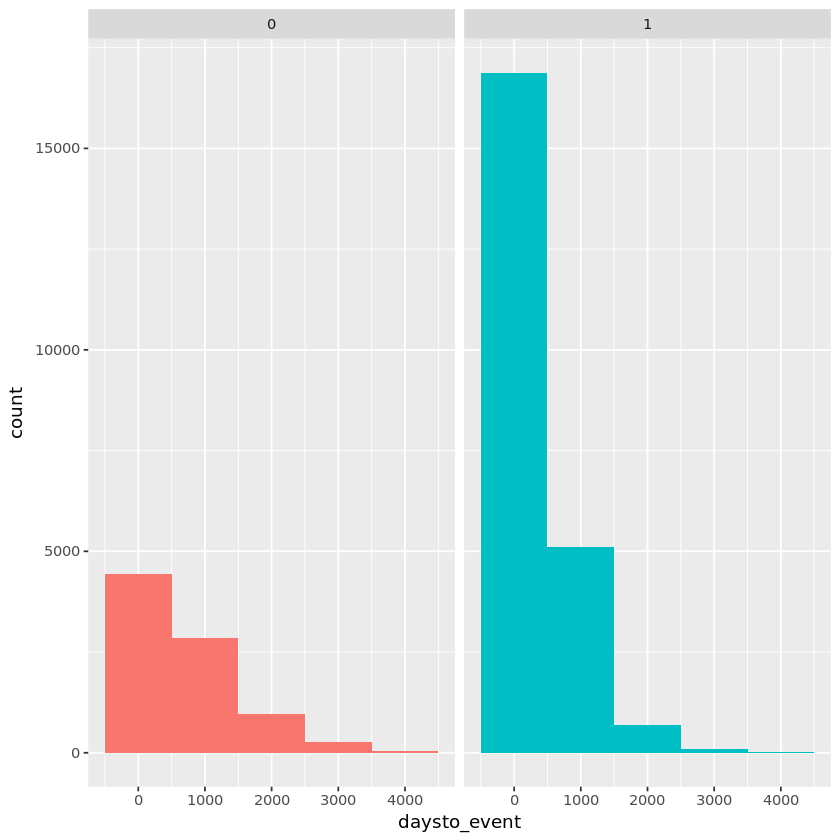

In [24]:
#Faceted histogram plot of number of "daystoevent" faceted by "eventdeath"
ggplot(flatiron_select, aes(x = daysto_event, fill = factor(event_died))) + geom_histogram(binwidth = 1000) + facet_grid(~event_died) + theme(legend.position = "none")

__2 histograms plotted showing the distribution of "daysto_event" dependent on whether the patient died or not. There are significantly more patients that died than those that were censored. The PERCENTAGE OF  of patient deaths THAT occurred in the first 1000 days WAS XXXXXXXXXX. __

In [26]:
install.packages("survival", "/tmp/RtmpopXkDN/downloaded_packages")

In [25]:
library("survival", lib.loc=.libPaths("/tmp/RtmpopXkDN/downloaded_packages"))


Attaching package: ‘survival’


The following object is masked from ‘package:caret’:

    cluster




In [26]:
#Count the number of censored patients 

sum(flatiron_select["event_died"] == 0)

[1] 8544

In [27]:
#Count the number of patients who DEFINITELY survived beyond 1000 days from index (first line starting tx)
#Assumption - any censored patient died at the time of being censored (they DIED IMMEDIATELY)
t = 1000
sum(flatiron_select["daysto_event"] > t)

[1] 4349

In [28]:
#Count the number of patients who MAY HAVE survived beyond 1000 days from index (firs line starting tx)
#Assumption - censored patients NEVER DIE
t = 1000
sum((flatiron_select["daysto_event"] > t) | (flatiron_train1["daysto_event"] == 0))

[1] 4349

In [29]:
#Count the number of paients who were not censored before 1000 days from index
#Assumption - they either had an event(death) before 1000, at 1000 or after 1000 (at any time) OR
#time of death occurs after (1000 days) - either they died or were censored at a later time after 1000 days
t = 1000
sum((flatiron_select["daysto_event"] == 1) | (flatiron_train1["daysto_event"] > t))

[1] 4399

In [30]:
#Exclude NA values while retaining original number of rows in dataset using na.exclude()
flatiron_select1 <- na.exclude(flatiron_select)

In [31]:
#5 fold cross validation
# Fit lm model using 5-fold CV: model


#set seed for model reproducibility
set.seed(42)
model <- train(
  daysto_event ~ ., 
  flatiron_select1,
  method = "lm",
  trControl = trainControl(
    method = "cv", 
    number = 5,
    verboseIter = TRUE
    
  )
)

# Print model to console
model

+ Fold1: intercept=TRUE 
- Fold1: intercept=TRUE 
+ Fold2: intercept=TRUE 
- Fold2: intercept=TRUE 
+ Fold3: intercept=TRUE 
- Fold3: intercept=TRUE 
+ Fold4: intercept=TRUE 
- Fold4: intercept=TRUE 
+ Fold5: intercept=TRUE 
- Fold5: intercept=TRUE 
Aggregating results
Fitting final model on full training set


Linear Regression 

30471 samples
   27 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 24377, 24376, 24377, 24377, 24377 
Resampling results:

  RMSE      Rsquared  MAE     
  528.5786  0.110594  372.1656

Tuning parameter 'intercept' was held constant at a value of TRUE

In [32]:
#Split datasets into Train/Predict sets
N_UK <- nrow(flatiron_select1)
N_UK

#Number of rows of training data required for model
target_UK <- round(N_UK * 0.75)
target_UK

#Creating vector of N_UK uniform variables
gp_UK <- runif(N_UK)

#Create training set flatiron_trainSet (75% of data) & flatiron_predictSet (25% of data)
flatiron_trainSet <- flatiron_select1[gp_UK < 0.75, ]
flatiron_validSet <- flatiron_select1[gp_UK >= 0.75, ]

#Examine flatiron_trainSet and flatiron_predictSet datasets
nrow(flatiron_trainSet)
nrow(flatiron_validSet)

[1] 30471

[1] 22853

[1] 22808

[1] 7663

In [35]:
install.packages("rms", "/tmp/RtmpopXkDN/downloaded_packages")

In [33]:
library("rms", lib.loc=.libPaths("/tmp/RtmpopXkDN/downloaded_packages"))

Loading required package: Hmisc

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve




In [34]:
#Fit a Multivariate COX PH regression analysis model
units(flatiron_trainSet$daysto_event) <- "Days"
dd <- datadist(flatiron_trainSet)
options(datadist = "dd")
fitCPH1 <- cph(Surv(daysto_event, event_died) ~ 
               biomarker_pdl1 + biomarker_egfr + biomarker_alk + biomarker_ros1  + ecog + bmi + 
               ageAtdiagnosis + biomarker_braf + biomarker_kras + yrsToprogress + TimetoTx + gender + 
               groupstage + smokingstatus + ecog + squam_cells + non_squamCells +  + Hisp_Latino + Black + 
               White + Asian + Chemotherapy + Immunotherapy + Hormone + TargBiologic + TargNonBiologic +
               AntibodyConj, 
               data = flatiron_trainSet, x = TRUE, y = TRUE, surv = TRUE, time.inc = 1) 

In [35]:
print(fitCPH1)

Cox Proportional Hazards Model
 
 cph(formula = Surv(daysto_event, event_died) ~ biomarker_pdl1 + 
     biomarker_egfr + biomarker_alk + biomarker_ros1 + ecog + 
     bmi + ageAtdiagnosis + biomarker_braf + biomarker_kras + 
     yrsToprogress + TimetoTx + gender + groupstage + smokingstatus + 
     ecog + squam_cells + non_squamCells + +Hisp_Latino + Black + 
     White + Asian + Chemotherapy + Immunotherapy + Hormone + 
     TargBiologic + TargNonBiologic + AntibodyConj, data = flatiron_trainSet, 
     x = TRUE, y = TRUE, surv = TRUE, time.inc = 1)
 
                          Model Tests       Discrimination    
                                                   Indexes    
 Obs      22808    LR chi2    1403.60       R2       0.060    
 Events   16582    d.f.            26    R2(26,22808)0.059    
 Center -0.2998    Pr(> chi2)  0.0000    R2(26,16582)0.080    
                   Score chi2 1377.56       Dxy      0.190    
                   Pr(> chi2)  0.0000                         


In [37]:
#Validating the model

validate(fitCPH1, method = "crossvalidation", B = 10, pr = FALSE)

      index.orig training   test optimism index.corrected  n
Dxy       0.1898   0.1899 0.1874   0.0025          0.1873 10
R2        0.0597   0.0598 0.0584   0.0014          0.0582 10
Slope     1.0000   1.0000 0.9840   0.0160          0.9840 10
D         0.0046   0.0047 0.0060  -0.0013          0.0059 10
U         0.0000   0.0000 0.0001  -0.0001          0.0001 10
Q         0.0046   0.0047 0.0059  -0.0012          0.0058 10
g         0.3342   0.3345 0.3288   0.0057          0.3285 10

In [86]:
install.packages("dynpred", "/tmp/RtmpopXkDN/downloaded_packages")

In [39]:
library("dynpred", "/tmp/RtmpopXkDN/downloaded_packages")

In [40]:
#Compute Harrell's concordance index on validation set
cindex(Surv(daysto_event, event_died) ~ yrsToprogress + bmi, data = flatiron_validSet)

$concordant
[1] 12252270

$total
[1] 22637044

$cindex
[1] 0.5412487

In [41]:
#Compute Harrell's concordance index on training set
cindex(Surv(daysto_event, event_died) ~ yrsToprogress + bmi, data = flatiron_trainSet)

$concordant
[1] 110511800

$total
[1] 203105923

$cindex
[1] 0.5441092

In [42]:
library("pec", "/tmp/RtmpopXkDN/downloaded_packages")

Loading required package: prodlim


Attaching package: ‘pec’


The following object is masked from ‘package:dynpred’:

    cindex


The following object is masked from ‘package:caret’:

    R2




In [43]:
#Compute concordance index for Cox Proportional Hazard Model 
A1 <- pec::cindex(list("Cox X1"=fitCPH1),
formula=Surv(daysto_event, event_died) ~ ecog + groupstage + smokingstatus + 
               squam_cells + non_squamCells + biomarker_pdl1 + biomarker_egfr + biomarker_alk 
               + biomarker_braf + biomarker_ros1 + biomarker_kras + bmi + ageAtdiagnosis + yrsToprogress + 
                TimetoTx + gender + Hisp_Latino + Black + White + Asian,
data=flatiron_select1,
eval.times=1)

In [44]:
head(A1)

$AppCindex
$AppCindex$`Cox X1`
[1] 0.6881716


$Pairs
$Pairs$`Cox X1`
[1] 1219622


$Concordant
$Concordant$`Cox X1`
[1] 839308.9


$call
pec::cindex(object = list(`Cox X1` = fitCPH1), formula = Surv(daysto_event, 
    event_died) ~ ecog + groupstage + smokingstatus + squam_cells + 
    non_squamCells + biomarker_pdl1 + biomarker_egfr + biomarker_alk + 
    biomarker_braf + biomarker_ros1 + biomarker_kras + bmi + 
    ageAtdiagnosis + yrsToprogress + TimetoTx + gender + Hisp_Latino + 
    Black + White + Asian, data = flatiron_select1, eval.times = 1)

$time
[1] 1

$pred.time
[1] 1


In [45]:
library("randomForestSRC", "/tmp/RtmpopXkDN/downloaded_packages")


 randomForestSRC 3.1.0 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 



Attaching package: ‘randomForestSRC’


The following object is masked from ‘package:Hmisc’:

    impute


The following object is masked from ‘package:purrr’:

    partial




In [46]:
rfs_model <- rfsrc(Surv(daysto_event, event_died) ~ ., 
                  data=flatiron_trainSet, ntree=1000, nsplit = 10)

In [47]:
print(rfs_model)

                         Sample size: 22808
                    Number of deaths: 16582
                     Number of trees: 1000
           Forest terminal node size: 15
       Average no. of terminal nodes: 1308.235
No. of variables tried at each split: 6
              Total no. of variables: 26
       Resampling used to grow trees: swor
    Resample size used to grow trees: 14415
                            Analysis: RSF
                              Family: surv
                      Splitting rule: logrank *random*
       Number of random split points: 10
                          (OOB) CRPS: 0.11134165
   (OOB) Requested performance error: 0.37727413



In [48]:
#Predict against the validation set 
rfs_pred <- predict(rfs_model, flatiron_validSet)
print(rfs_pred)

  Sample size of test (predict) data: 7663
                Number of grow trees: 1000
  Average no. of grow terminal nodes: 1308.235
         Total no. of grow variables: 26
       Resampling used to grow trees: swor
    Resample size used to grow trees: 14415
                            Analysis: RSF
                              Family: surv
                                CRPS: 0.13174482
         Requested performance error: 0.38112056



In [49]:
#Compute Concordance index for random forest survival model
A2 <- pec::cindex(list("rfsrc"= rfs_model),
formula=Surv(daysto_event, event_died) ~ ecog + groupstage + smokingstatus + 
               squam_cells + non_squamCells + biomarker_pdl1 + biomarker_egfr + biomarker_alk 
               + biomarker_braf + biomarker_ros1 + biomarker_kras + bmi + ageAtdiagnosis + 
                TimetoTx + gender + Hisp_Latino + Black + White + Asian,
data=flatiron_select1,
eval.times=1)

In [50]:
head(A2)

$AppCindex
$AppCindex$rfsrc
[1] 0.8518762


$Pairs
$Pairs$rfsrc
[1] 1219622


$Concordant
$Concordant$rfsrc
[1] 1038967


$call
pec::cindex(object = list(rfsrc = rfs_model), formula = Surv(daysto_event, 
    event_died) ~ ecog + groupstage + smokingstatus + squam_cells + 
    non_squamCells + biomarker_pdl1 + biomarker_egfr + biomarker_alk + 
    biomarker_braf + biomarker_ros1 + biomarker_kras + bmi + 
    ageAtdiagnosis + TimetoTx + gender + Hisp_Latino + Black + 
    White + Asian, data = flatiron_select1, eval.times = 1)

$time
[1] 1

$pred.time
[1] 1


__FOR THE TEST DATASET__

In [52]:
flatiron_test <- read_csv("/pharml/data/flatiron_leaderboard.csv")
head(flatiron_test)

Rows: 4476 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): patientid, ecog, histology, groupstage, smokingstatus, gender, rac...
dbl  (5): diagnosis_nsclc_year, diagnosis_ansclc_year, birthyear, bmi, index...
lgl  (6): biomarker_pdl1, biomarker_alk, biomarker_ros1, biomarker_braf, bio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


patientid,diagnosis_nsclc_year,diagnosis_ansclc_year,ecog,histology,groupstage,smokingstatus,birthyear,gender,raceethnicity,⋯,biomarker_alk,biomarker_ros1,biomarker_braf,biomarker_egfr,biomarker_kras,lab_creatinine,lab_alanineaminotransferase,lab_ldh,bmi,index_lot1_year
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
PHARML000007,2019,2019,Unknown,Non-squamous cell carcinoma,Stage IVA,History of smoking,1942,M,Other Race,⋯,NA,NA,NA,NA,NA,NA,NA,NA,22.41212,2019
PHARML000016,2013,2014,2,Squamous cell carcinoma,Stage IIIA,History of smoking,1961,M,Other Race,⋯,NA,NA,NA,NA,NA,normal,normal,abnormal,23.47288,2014
PHARML000038,2016,2017,0,Non-squamous cell carcinoma,Stage IIA,History of smoking,1967,F,Hispanic or Latino (any),⋯,NA,NA,NA,NA,NA,NA,NA,NA,29.11700,2017
PHARML000047,2017,2017,0,Non-squamous cell carcinoma,Stage IV,History of smoking,1942,M,Hispanic or Latino (any),⋯,NA,NA,NA,NA,NA,NA,NA,NA,27.80949,2017
PHARML000052,2017,2017,1,Squamous cell carcinoma,Stage IIIB,History of smoking,1946,M,Hispanic or Latino (any),⋯,NA,NA,NA,NA,NA,NA,NA,NA,29.50382,2017
PHARML000059,2013,2015,0,Squamous cell carcinoma,Stage IA,History of smoking,1937,M,Hispanic or Latino (any),⋯,NA,NA,NA,NA,NA,abnormal,normal,normal,28.05609,2015


In [53]:
summary(flatiron_test)

  patientid         diagnosis_nsclc_year diagnosis_ansclc_year
 Length:4476        Min.   :1994         Min.   :2011         
 Class :character   1st Qu.:2014         1st Qu.:2014         
 Mode  :character   Median :2016         Median :2017         
                    Mean   :2016         Mean   :2017         
                    3rd Qu.:2019         3rd Qu.:2019         
                    Max.   :2022         Max.   :2022         
                    NA's   :2                                 
     ecog            histology          groupstage        smokingstatus     
 Length:4476        Length:4476        Length:4476        Length:4476       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                  

In [54]:
unique(flatiron_test$biomarker_egfr)

[1]    NA FALSE  TRUE

In [55]:
flatiron_test1 <- flatiron_test %>% filter(!is.na(diagnosis_nsclc_year))
summary(flatiron_test1)

  patientid         diagnosis_nsclc_year diagnosis_ansclc_year
 Length:4474        Min.   :1994         Min.   :2011         
 Class :character   1st Qu.:2014         1st Qu.:2014         
 Mode  :character   Median :2016         Median :2017         
                    Mean   :2016         Mean   :2017         
                    3rd Qu.:2019         3rd Qu.:2019         
                    Max.   :2022         Max.   :2022         
                                                              
     ecog            histology          groupstage        smokingstatus     
 Length:4474        Length:4474        Length:4474        Length:4474       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                  

In [56]:
flatiron_test1 <- flatiron_test1 %>% replace_with_na(replace = list(bmi = "<NA>"))

In [57]:
toReplace1 <- which(is.na(flatiron_test1$bmi))
flatiron_test1$bmi[toReplace1] <- 19.0

In [58]:
#Label encode categorical variables
label <- LabelEncoder$new()
print(label$fit(flatiron_test1$ecog))
flatiron_test1$ecog <- label$fit_transform(flatiron_test1$ecog)

label <- LabelEncoder$new()
print(label$fit(flatiron_test1$groupstage))
flatiron_test1$groupstage <- label$fit_transform(flatiron_test1$groupstage)

label <- LabelEncoder$new()
print(label$fit(flatiron_test1$smokingstatus))
flatiron_test1$smokingstatus <- label$fit_transform(flatiron_test1$smokingstatus)

label <- LabelEncoder$new()
print(label$fit(flatiron_test1$gender))
flatiron_test1$gender <- label$fit_transform(flatiron_test1$gender)

label <- LabelEncoder$new()
print(label$fit(flatiron_test1$lab_ldh))
flatiron_test1$lab_ldh <- label$fit_transform(flatiron_test1$lab_ldh)

label <- LabelEncoder$new()
print(label$fit(flatiron_test1$lab_alanineaminotransferase))
flatiron_test1$lab_alanineaminotransferase <- label$fit_transform(flatiron_test1$lab_alanineaminotransferase)

label <- LabelEncoder$new()
print(label$fit(flatiron_test1$lab_creatinine))
flatiron_test1$lab_creatinine <- label$fit_transform(flatiron_test1$lab_creatinine)

label <- LabelEncoder$new()
print(label$fit(flatiron_test1$biomarker_pdl1))
flatiron_test1$biomarker_pdl1 <- label$fit_transform(flatiron_test1$biomarker_pdl1)

label <- LabelEncoder$new()
print(label$fit(flatiron_test1$biomarker_alk))
flatiron_test1$biomarker_alk <- label$fit_transform(flatiron_test1$biomarker_alk)

label <- LabelEncoder$new()
print(label$fit(flatiron_test1$biomarker_ros1))
flatiron_test1$biomarker_ros1 <- label$fit_transform(flatiron_test1$biomarker_ros1)

label <- LabelEncoder$new()
print(label$fit(flatiron_test1$biomarker_braf))
flatiron_test1$biomarker_braf <- label$fit_transform(flatiron_test1$biomarker_braf)

label <- LabelEncoder$new()
print(label$fit(flatiron_test1$biomarker_egfr))
flatiron_test1$biomarker_egfr <- label$fit_transform(flatiron_test1$biomarker_egfr)

label <- LabelEncoder$new()
print(label$fit(flatiron_test1$biomarker_kras))
flatiron_test1$biomarker_kras <- label$fit_transform(flatiron_test1$biomarker_kras)

[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE


The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



[1] TRUE


The data contains NA values. Imputing NA with 'NA' 



In [59]:
#Mutate in age at diagnosis etc
flatiron_test2 <- flatiron_test1 %>% mutate(ageAtdiagnosis = diagnosis_nsclc_year - birthyear, 
    yrsToprogress = diagnosis_ansclc_year - diagnosis_nsclc_year, 
                                              TimetoTx = index_lot1_year - diagnosis_nsclc_year)
head(flatiron_test2)

patientid,diagnosis_nsclc_year,diagnosis_ansclc_year,ecog,histology,groupstage,smokingstatus,birthyear,gender,raceethnicity,⋯,biomarker_egfr,biomarker_kras,lab_creatinine,lab_alanineaminotransferase,lab_ldh,bmi,index_lot1_year,ageAtdiagnosis,yrsToprogress,TimetoTx
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PHARML000007,2019,2019,0,Non-squamous cell carcinoma,0,0,1942,0,Other Race,⋯,0,0,0,0,0,22.41212,2019,77,0,0
PHARML000016,2013,2014,1,Squamous cell carcinoma,1,0,1961,0,Other Race,⋯,0,0,1,1,1,23.47288,2014,52,1,1
PHARML000038,2016,2017,2,Non-squamous cell carcinoma,2,0,1967,1,Hispanic or Latino (any),⋯,0,0,0,0,0,29.11700,2017,49,1,1
PHARML000047,2017,2017,2,Non-squamous cell carcinoma,3,0,1942,0,Hispanic or Latino (any),⋯,0,0,0,0,0,27.80949,2017,75,0,0
PHARML000052,2017,2017,3,Squamous cell carcinoma,4,0,1946,0,Hispanic or Latino (any),⋯,0,0,0,0,0,29.50382,2017,71,0,0
PHARML000059,2013,2015,2,Squamous cell carcinoma,5,0,1937,0,Hispanic or Latino (any),⋯,0,0,2,1,2,28.05609,2015,76,2,2


In [60]:
#One hot encode non-ordinal categorical variables
flatiron_test3 <- flatiron_test2 %>% 
                        mutate(squam_cells = ifelse(histology == "Squamous cell carcinoma", 1, 0), 
                        non_squamCells = ifelse(histology == "Non-squamous cell carcinoma", 1, 0), 
                        NSCLC = ifelse(histology == "NSCLC histology NOS", 1, 0), 
                        Hisp_Latino = ifelse(raceethnicity == "Hispanic or Latino (any)", 1, 0), 
                        White = ifelse(raceethnicity == "Non-Hispanic White", 1, 0), 
                        Black = ifelse(raceethnicity == "Non-Hispanic Black", 1, 0), 
                        Asian = ifelse(raceethnicity == "Non-Hispanic Asian", 1, 0), 
                        Other_Race = ifelse(raceethnicity == "Other Race", 1, 0),
                        Midwest = ifelse(region == "Midwest", 1, 0),
                        Northeast = ifelse(region == "Northeast", 1, 0),
                        South = ifelse(region == "South", 1, 0),
                        West = ifelse(region == "West", 1, 0),
                        Other = ifelse(region == "0", 1, 0),
                        Chemotherapy = ifelse(lot_category == "Chemotherapy", 1, 0),
                        Immunotherapy = ifelse(lot_category == "Immunotherapy", 1, 0),
                        TargBiologic = ifelse(lot_category == "Targeted/Biologic", 1, 0),
                        TargNonBiologic = ifelse(lot_category == "Targeted/Non-Biologic", 1, 0),
                        Hormone = ifelse(lot_category == "Hormone", 1, 0),
                        AntibodyConj = ifelse(lot_category == "Antibody-Conjugate", 1, 0),
                        Cytoprotective = ifelse(lot_category == "Cytoprotective", 1, 0))
                               
head(flatiron_test3)

patientid,diagnosis_nsclc_year,diagnosis_ansclc_year,ecog,histology,groupstage,smokingstatus,birthyear,gender,raceethnicity,⋯,South,West,Other,Chemotherapy,Immunotherapy,TargBiologic,TargNonBiologic,Hormone,AntibodyConj,Cytoprotective
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PHARML000007,2019,2019,0,Non-squamous cell carcinoma,0,0,1942,0,Other Race,⋯,1,0,0,0,0,0,0,0,0,0
PHARML000016,2013,2014,1,Squamous cell carcinoma,1,0,1961,0,Other Race,⋯,1,0,0,1,0,0,0,0,0,0
PHARML000038,2016,2017,2,Non-squamous cell carcinoma,2,0,1967,1,Hispanic or Latino (any),⋯,0,0,0,0,1,0,0,0,0,0
PHARML000047,2017,2017,2,Non-squamous cell carcinoma,3,0,1942,0,Hispanic or Latino (any),⋯,1,0,0,NA,NA,NA,NA,NA,NA,NA
PHARML000052,2017,2017,3,Squamous cell carcinoma,4,0,1946,0,Hispanic or Latino (any),⋯,1,0,0,0,0,0,0,0,0,0
PHARML000059,2013,2015,2,Squamous cell carcinoma,5,0,1937,0,Hispanic or Latino (any),⋯,0,1,0,0,0,0,0,0,0,0


In [61]:
#Select out non-essential columns
flatiron_selectTest <- flatiron_test3 %>% select(-diagnosis_nsclc_year, -diagnosis_ansclc_year, -histology, 
                            -raceethnicity, -region, -lot_category, -index_lot1_year, -Midwest, -South,
                               -Other_Race, -Northeast, -West, -Other, -lab_ldh, -birthyear,
                            -lab_alanineaminotransferase, -lab_creatinine, -patientid, -Cytoprotective, 
                            -Other, -Other_Race, -NSCLC)

In [62]:
head(flatiron_selectTest)

ecog,groupstage,smokingstatus,gender,biomarker_pdl1,biomarker_alk,biomarker_ros1,biomarker_braf,biomarker_egfr,biomarker_kras,⋯,Hisp_Latino,White,Black,Asian,Chemotherapy,Immunotherapy,TargBiologic,TargNonBiologic,Hormone,AntibodyConj
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,2,0,1,0,0,0,0,0,0,⋯,1,0,0,0,0,1,0,0,0,0
2,3,0,0,0,0,0,0,0,0,⋯,1,0,0,0,NA,NA,NA,NA,NA,NA
3,4,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0


In [63]:
#Exclude NA values 
flatiron_selectTest2 <- na.exclude(flatiron_selectTest)

In [64]:
summary(flatiron_selectTest2)

      ecog         groupstage     smokingstatus        gender      
 Min.   :0.000   Min.   : 0.000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:1.000   1st Qu.: 3.000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :2.000   Median : 3.000   Median :0.0000   Median :0.0000  
 Mean   :1.842   Mean   : 3.823   Mean   :0.1325   Mean   :0.4818  
 3rd Qu.:3.000   3rd Qu.: 4.000   3rd Qu.:0.0000   3rd Qu.:1.0000  
 Max.   :5.000   Max.   :17.000   Max.   :2.0000   Max.   :1.0000  
 biomarker_pdl1    biomarker_alk     biomarker_ros1    biomarker_braf   
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000   Median :0.00000  
 Mean   :0.01055   Mean   :0.01766   Mean   :0.01169   Mean   :0.00986  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :2.00000   Max.   :1.00000   Max.   :1.00000   Max.   :2.00000  
 biomarker_eg

In [65]:
#Using trained rsf model to predict against test set
rfs_predTest <- predict(rfs_model, flatiron_selectTest2)
print(rfs_predTest)

  Sample size of test (predict) data: 4361
                Number of grow trees: 1000
  Average no. of grow terminal nodes: 1308.235
         Total no. of grow variables: 26
       Resampling used to grow trees: swor
    Resample size used to grow trees: 14415
                            Analysis: RSF
                              Family: surv


In [66]:
head(rfs_predTest)

$call
generic.predict.rfsrc(object = object, newdata = newdata, m.target = m.target, 
    importance = importance, get.tree = get.tree, block.size = block.size, 
    na.action = na.action, outcome = outcome, perf.type = perf.type, 
    proximity = proximity, forest.wt = forest.wt, ptn.count = ptn.count, 
    distance = distance, var.used = var.used, split.depth = split.depth, 
    seed = seed, do.trace = do.trace, membership = membership, 
    statistics = statistics)

$family
[1] "surv"

$n
[1] 4361

$ntree
[1] 1000

$yvar
NULL

$yvar.names
[1] "daysto_event" "event_died"  
